# Indoor Climbing Hold Segmentation

This Jupyter notebook is an interactive overview of the major components of https://github.com/xiaoxiae/Indoor-Climbing-Hold-and-Route-Segmentation.

Before running the repository, make sure you have downloaded the appropriate datasets from https://www.kaggle.com/tomasslama/indoor-climbing-gym-hold-segmentation and placed them in their respective folders in `data/`.
Also make sure that you have installed the required Python packages, which are those found in `requirements.txt` and also include the [PyTorch](https://pytorch.org/get-started/locally/) and [detectron2 library](https://detectron2.readthedocs.io/en/latest/tutorials/install.html) libraries (whose installations depend on your particular system).

## Hold Segmentation

### Standard Approach

The standard approach can be broadly separated into the following parts:
1. detect blobs, which are centers of holds
2. detect edges, which are outlines of holds
3. for each blob, find a threshold such that the contour fits the outline

Each of the functions that process the images are configured with sane defaults, refer to `std/utils.py` if you wish to change them.

#### Blob detection

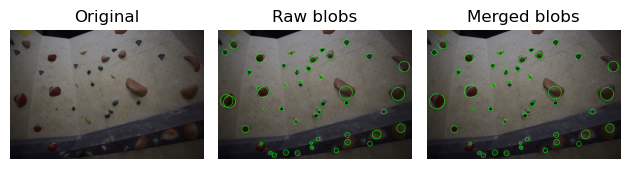

In [1]:
from std.utils import *
from matplotlib import pyplot as plt


img = cv.imread('data/sm/298.jpg')

# blob detection
keypoints = detect_blobs(img)
img_blobs = img.copy()
draw_keypoints(img_blobs, keypoints)

# merge blobs that have an overlapping
keypoints = merge_blobs(keypoints)
img_blobs_merged = img.copy()
draw_keypoints(img_blobs_merged, keypoints)                                                     


# display the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_blobs[:, :, ::-1])
ax2.axis('off')
ax2.set_title('Raw blobs')

ax3.imshow(img_blobs_merged[:, :, ::-1])
ax3.axis('off')
ax3.set_title('Merged blobs')

fig.tight_layout()
plt.show()

#### Edge detection

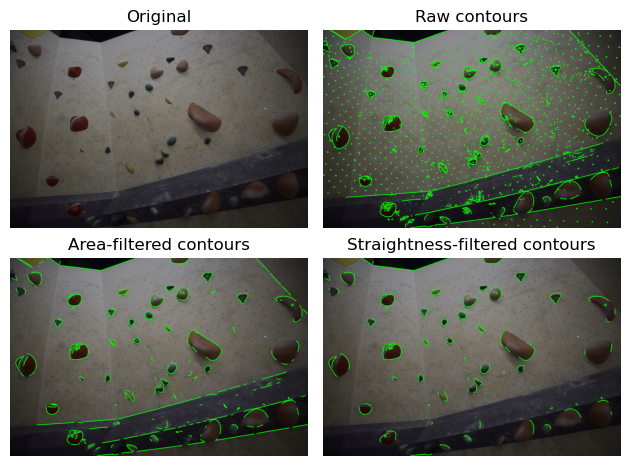

In [2]:
# blur the image for smoother edges
blur = gaussian_blur(img)

# find the contours
edges = canny(blur)
contours = find_contours(edges)

img_contours = img.copy()
draw_contours(img_contours, contours)

contours = filter_size_contours(contours)
img_contours_area = img.copy()
draw_contours(img_contours_area, contours)

contours = filter_straight_contours(contours)
img_contours_straight = img.copy()
draw_contours(img_contours_straight, contours)


# display the results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_contours[:, :, ::-1])
ax2.axis('off')
ax2.set_title('Raw contours')

ax3.imshow(img_contours_area[:, :, ::-1])
ax3.axis('off')
ax3.set_title('Area-filtered contours')

ax4.imshow(img_contours_straight[:, :, ::-1])
ax4.axis('off')
ax4.set_title('Straightness-filtered contours')

fig.tight_layout()
plt.show()

#### Combining the approaches

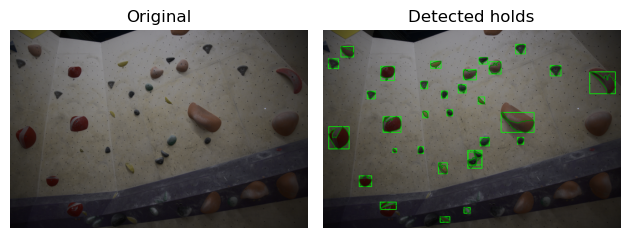

In [3]:
# contours are simplified to speed up the detection
contours = simplify_contours(contours)

# approximate holds by their contours
# returns a dictionary of keypoint-contour
# NOTE that this step can take a few minutes, depending on a number of keypoints
hold_approximations = detect_holds(img, keypoints, contours)

img_holds = img.copy()
draw_contour_boxes(img_holds, list(hold_approximations.values()), color=(0, 255, 0))
draw_contours(img_holds, list(hold_approximations.values()), color=(0, 128, 0))


# display the results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_holds[:, :, ::-1])
ax2.axis('off')
ax2.set_title('Detected holds')

fig.tight_layout()
plt.show()

### Learning-based Approach

For this demo, we load the config and weigths from the `Basic_Augmented_P2P3_DoubleTopK_NMS_2KIT` model and show the results on a sample image. Weights and config can be downloaded from Kaggle https://www.kaggle.com/datasets/tomasslama/indoor-climbing-gym-hold-segmentation and must be placed in the `ml/weights` folder.

/home/xiaoxiae/.local/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


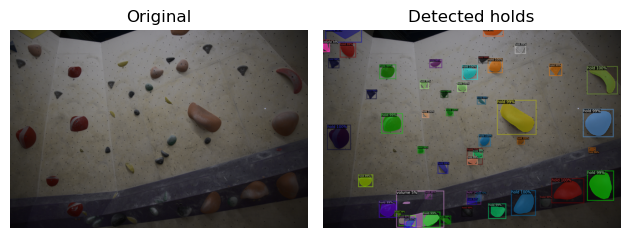

In [4]:
import cv2
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Get config and weigths for model
cfg = get_cfg()
cfg.merge_from_file("ml/weights/experiment_config.yml")
cfg.MODEL.WEIGHTS = "ml/weights/model_final.pth"
cfg.MODEL.DEVICE='cpu'
# Set metadata, in this case only the class names for plotting
MetadataCatalog.get("meta").thing_classes = ["hold", "volume"]
metadata = MetadataCatalog.get("meta")

predictor = DefaultPredictor(cfg)

img = cv2.imread("data/sm/298.jpg")
outputs = predictor(img)
v = Visualizer(
    img[:, :, ::-1],
    metadata=metadata
)

out_predictions = v.draw_instance_predictions(outputs["instances"].to("cpu"))
img_holds = out_predictions.get_image()

# display the results
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img[:, :, ::-1])
ax1.axis('off')
ax1.set_title('Original')

ax2.imshow(img_holds)
ax2.axis('off')
ax2.set_title('Detected holds')

fig.tight_layout()
plt.show()

## Route Detection

### Standard Approach

In [5]:
import cv2
import numpy as np
from ml.utils import create_dataset_dicts, plot_routes
from collections import defaultdict
from sklearn.cluster import KMeans
import pandas as pd
from std.utils import get_color_moments, find_hold_contours


# obtain a sample image and hold annotations to be used for route segmentation
dataset_dicts = create_dataset_dicts("data/bh")
d_dict = dataset_dicts["data/bh/0457.jpg"]
image = cv2.imread(d_dict["file_name"])
image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

#### Clustering for Mean colors

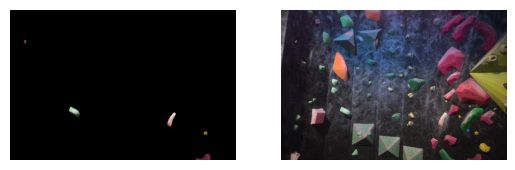

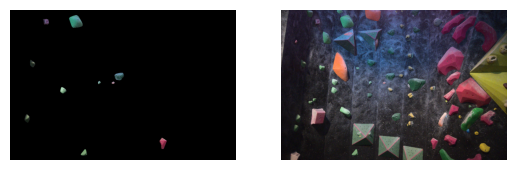

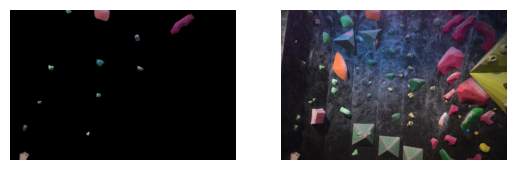

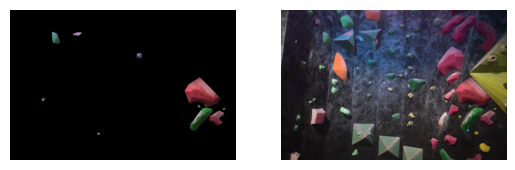

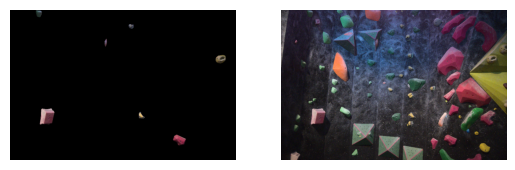

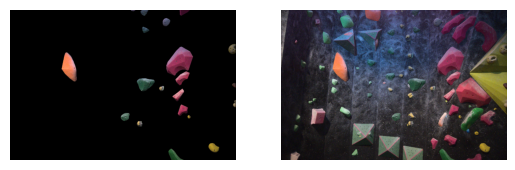

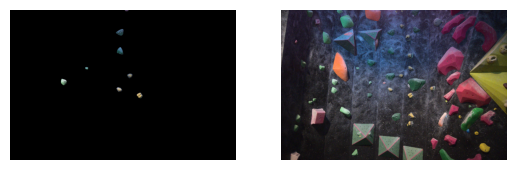

In [6]:
contours = find_hold_contours(image, d_dict)
clustering_input = pd.DataFrame()
for idx, contour in enumerate(contours):
    masked = np.zeros_like(image[:, :, 0])
    cv2.drawContours(masked, [contour], 0, 255, -1)

    B_mean, G_mean, R_mean, _ = cv2.mean(image, mask=masked)
    df = pd.DataFrame({'B_mean': B_mean, 'G_mean': G_mean, 'R_mean': R_mean}, index=[idx])
    clustering_input = pd.concat([clustering_input, df])

km = KMeans( n_clusters=7, n_init="auto")
km.fit_predict(clustering_input)

routes_dict = defaultdict(list)
for id, cluster in zip(range(clustering_input.shape[0]), km.labels_):
    routes_dict[cluster].append(id)

figures_axes = plot_routes(routes_dict, d_dict)
for (fig, ax) in figures_axes:
    fig.canvas.draw()

#### Clustering for Color moments

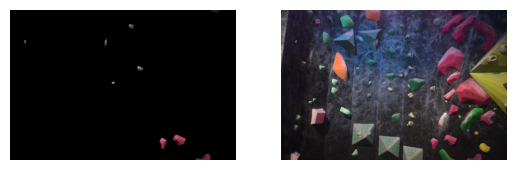

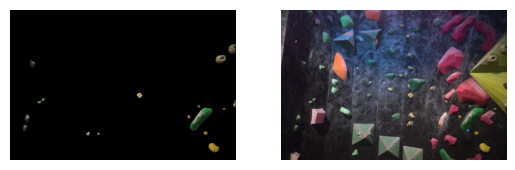

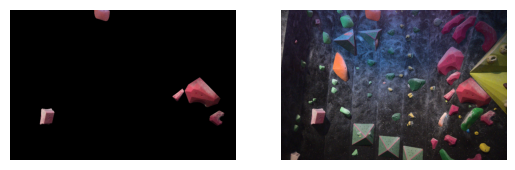

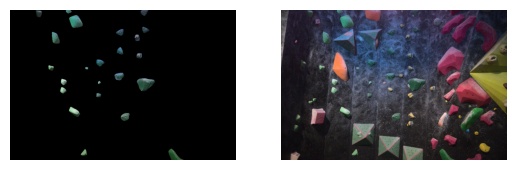

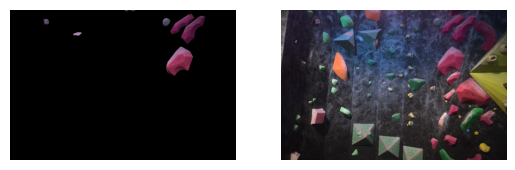

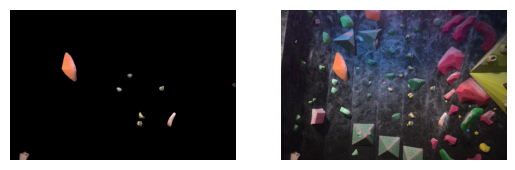

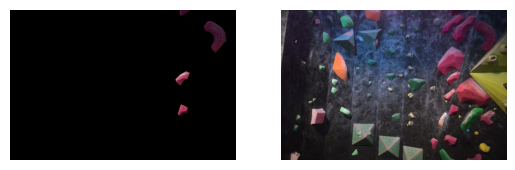

In [7]:
clustering_input = get_color_moments(image_hsv, d_dict) # calculate mean and std of H channel
km_moments = KMeans(n_clusters=7, random_state=42, n_init="auto")

km_moments.fit_predict(clustering_input)

routes_dict = defaultdict(list)
for id, cluster in zip(range(clustering_input.shape[0]), km_moments.labels_):
    routes_dict[cluster].append(id)

figures_axes = plot_routes(routes_dict, d_dict)
for (fig, ax) in figures_axes:
    fig.canvas.draw()

### Learning-based Approach

In [8]:
import cv2
import torch
import random
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.data import MetadataCatalog
from ml.route_networks import TripletNet
from collections import defaultdict
from ml.utils import plot_routes_instances, instance_to_hold
random.seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Get config and weigths for model
cfg = get_cfg()
cfg.merge_from_file("ml/weights/experiment_config.yml")
cfg.MODEL.WEIGHTS = "ml/weights/model_final.pth"
cfg.MODEL.DEVICE='cpu'
# Set metadata, in this case only the class names for plotting
MetadataCatalog.get("meta").thing_classes = ["hold", "volume"]
metadata = MetadataCatalog.get("meta")

predictor = DefaultPredictor(cfg)

# Get holds
img = cv2.imread("data/bh/0457.jpg")
outputs = predictor(img)

# Load weigths for TripletNet
triplet_model = TripletNet().to(device)
triplet_model.load_state_dict(torch.load("ml/weights/triplet_network_final.pt", map_location=device))

<All keys matched successfully>

defaultdict(<class 'list'>, {0: [14, 1, 2, 7, 11, 14, 20, 21, 22, 24, 31, 32, 35, 36, 37, 38, 46, 47, 51, 56, 58, 59, 60, 62, 65, 69, 71], 1: [0, 3, 8, 10, 15, 34, 49, 54, 66, 67], 2: [4, 13, 16, 17, 18, 19, 23, 27, 29, 40, 43, 44, 45, 48, 53, 55, 57, 63, 64, 68, 70], 3: [5, 9, 12, 25, 26, 28, 30, 33, 39, 42, 61], 4: [6], 5: [41, 50, 52]})


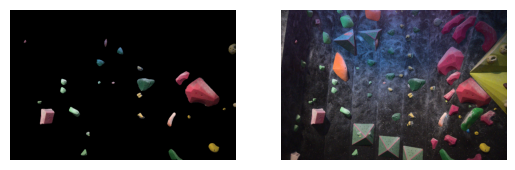

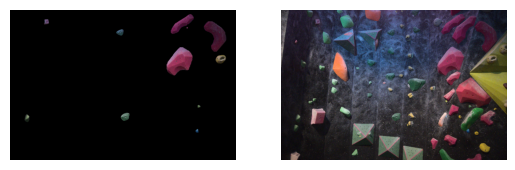

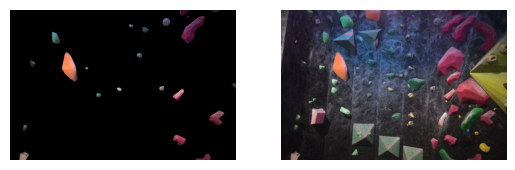

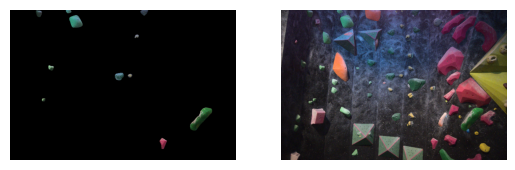

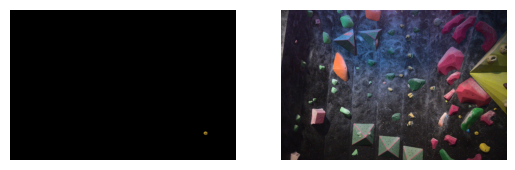

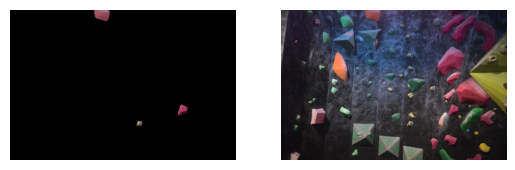

In [9]:
instances = outputs["instances"]

# Filter to only include holds with scorces > 0.7
instances = instances[instances.pred_classes == 0]
instances = instances[instances.scores > 0.7]

# Initialize routes with random seed hold
routes_dict = defaultdict(list)
routes_dict[0] = [random.randint(0,len(instances)-1)]

for hold_idx in range(len(instances)):
    for route_id, holds in routes_dict.items():
        dists = []
        for route_hold_idx in holds:
            with torch.no_grad():
                input1 = instance_to_hold(instances[hold_idx], img, triplet_model.preprocess ,device).unsqueeze(0)
                input2 = instance_to_hold(instances[route_hold_idx], img, triplet_model.preprocess, device).unsqueeze(0)
                output1 = triplet_model(input1)
                output2 = triplet_model(input2)
            dist = torch.nn.functional.pairwise_distance(output1, output2).square().item()
            dists.append(dist)
        if np.median(np.array(dists)) <= 0.7 and np.max(dists) <= 2.65:
            # Current hold is similar to all holds in existing route => Adding it to that route
            routes_dict[route_id].append(hold_idx)
            break
    else:
        # Current hold is not similar to any holds on existing routes => Add new route
        routes_dict[max(routes_dict.keys()) + 1].append(hold_idx)
print(routes_dict)

figures_axes = plot_routes_instances(routes_dict, instances, img)
for (fig, ax) in figures_axes:
    fig.canvas.draw()